In [1]:
import numpy as np
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf

IndentationError: expected an indented block (BlockSync_current.py, line 1430)

In [2]:
# define a single block to figure things out with:
# this step creates block_collection - a list of BlockSync objects of interest
block_numbers = range(24,25)
bad_blocks = [42, 61, 62, 64, 65, 66]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
animal = 'PV_62'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks)
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b



instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!


In [3]:
block_collection

[BlockSync object for animal PV_62 with 
 block_num 024 at date 2023-04-27_11-22-56]

In [3]:
# This step is used to quickly go over the analyzed blocks and load their internal data
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

running parse_open_ephys_events...
block 024 has a parsed events file, reading...
getting eye brigtness values for block 024...
found a file!
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder


In [4]:
# This is a continuation of the previous - more data loadings
for block in block_collection:
    block.import_manual_sync_df()
    block.read_dlc_data()

eye dataframes loaded from analysis folder


In [10]:
block.get_jitter_reports(export=True, overwrite=True)

Computing Cross-Correlation:   0%|          | 433/95744 [00:02<10:16, 154.65frame/s]C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:1253: RuntimeWarning: invalid value encountered in true_divide
  out = out / np.sqrt(image * template)
Computing Cross-Correlation: 100%|█████████▉| 95743/95744 [10:18<00:00, 154.69frame/s]


results saved to Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\analysis\jitter_report_dict.pkl
Jitter report computed - check out re/le_jitter_dict attributes


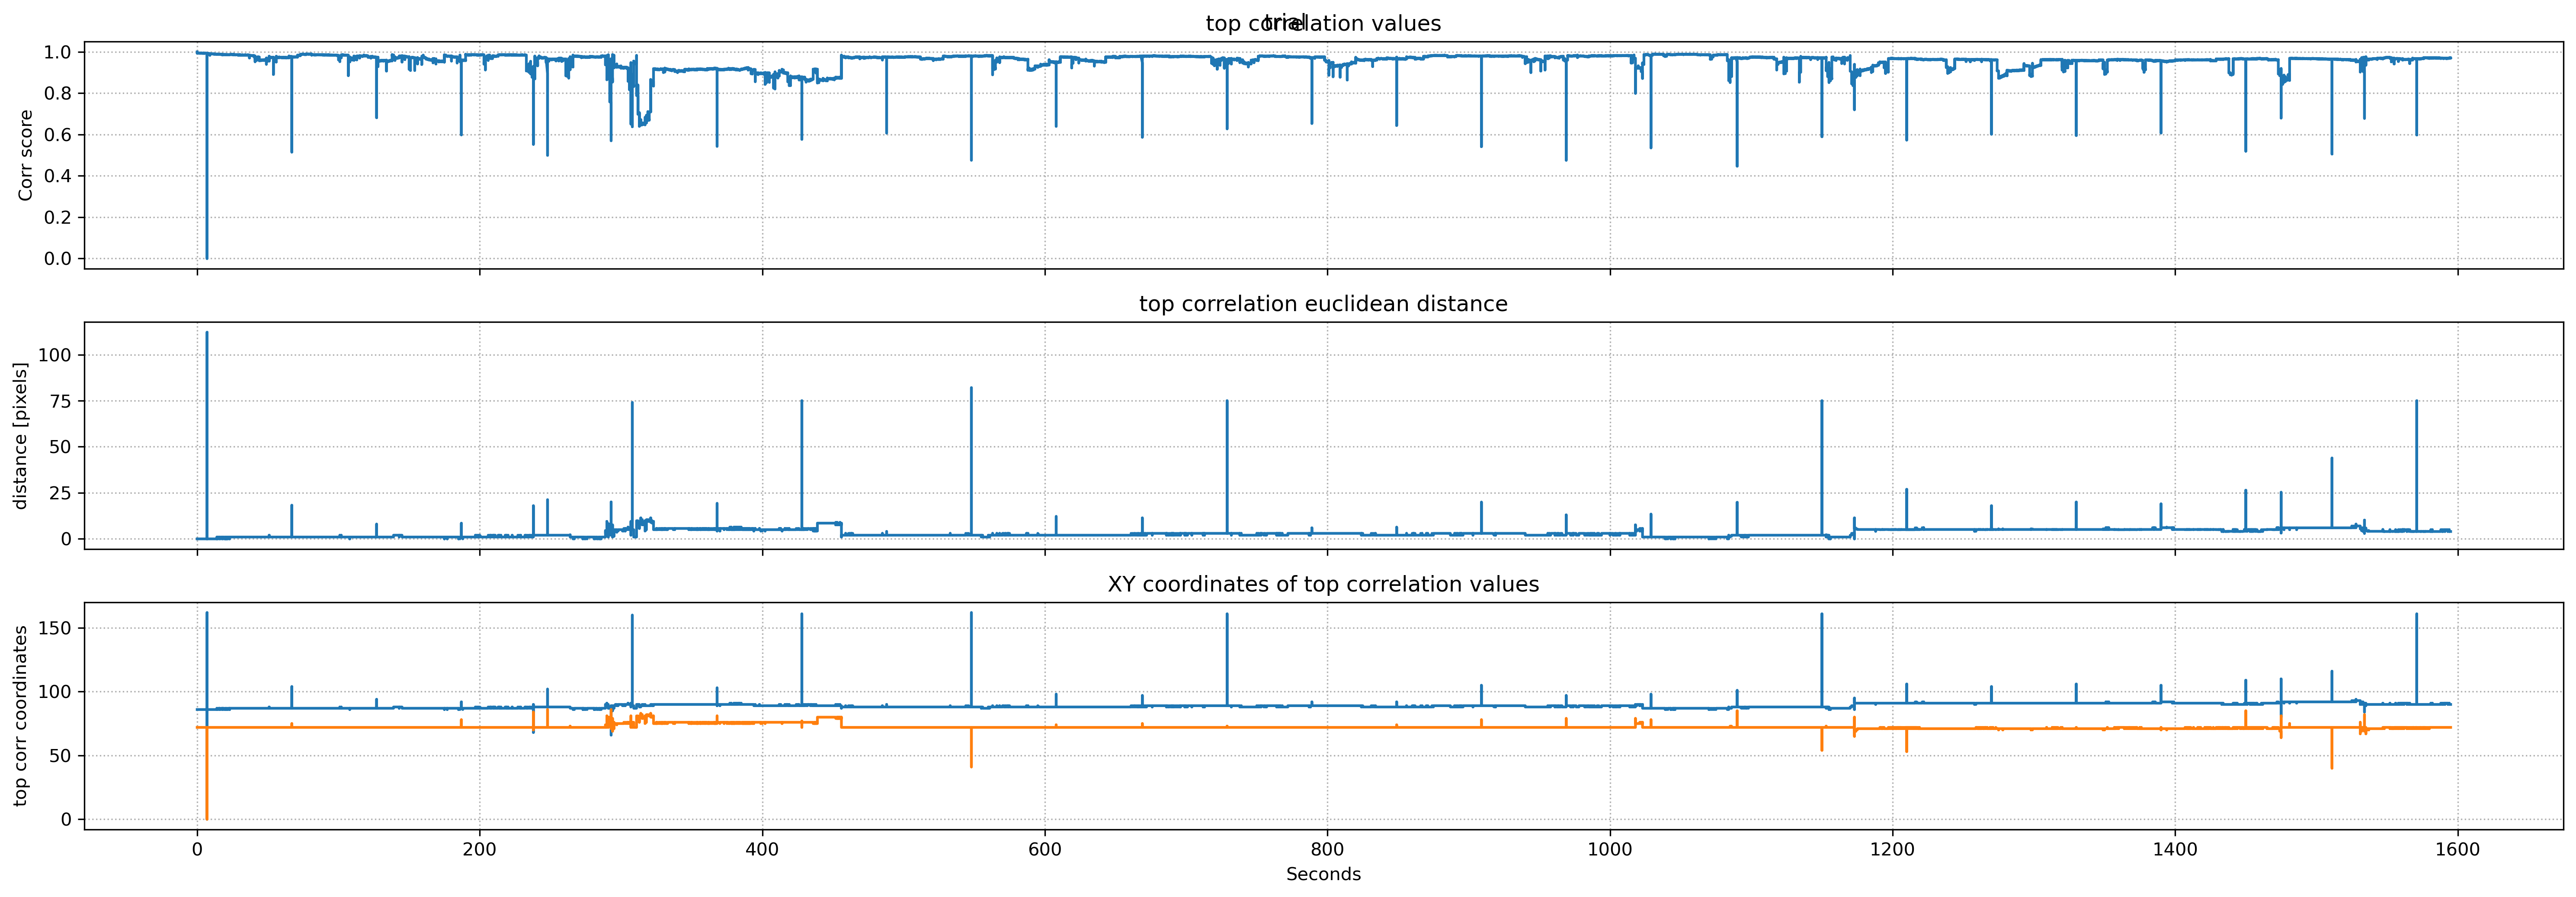

In [44]:
fig = block.plot_correlation_vectors(block.le_jitter_dict,fig_suptitle='trial')

In [41]:
block

BlockSync object for animal PV_62 with 
block_num 024 at date 2023-04-27_11-22-56

In [19]:
block.re_jitter_dict.keys()

dict_keys(['top_correlation_values', 'top_correlation_dist', 'top_correlation_xy', 'y_displacement', 'x_displacement'])

In [43]:
dist = block.le_jitter_dict['top_correlation_dist']
diffs = np.diff(np.where(np.array(dist) > 50)[0])
len(diffs[diffs>5])

6

In [ ]:
"""
This function cascades over the steps that end in two dataframe objects, one for synced saccades and the other
        non-synced saccades. This function requires completion of all previous analysis steps (in particular, lizMov.mat
        should be produced using mark's code)

        There is now a possibility to create a 3d based saccade dictionary where the XY coordinates are replaced by phi / theta approximations
        utilizing the pye3d module (different code, should be run separately before running the 3d version of saccade_dict_creation)
"""
for block in block_collection:
    print(block)
    block.saccade_dict_creation(sampling_window_ms=2000,
                                ep_channel_number=5,
                                automate_saccade_detection=True,
                                overwrite_saccade_data=False)

In [ ]:
block.block_eye_plot()

In [ ]:
block.le_df

In [ ]:
# This cell sorts the saccade data from the BlockSync objects into dataframes
block_sync_dfs = [block.synced_saccades_df for block in block_collection]
stacked_synced_df = pd.concat(block_sync_dfs, ignore_index=True)
block_non_synced_dfs = [block.non_synced_saccades_df for block in block_collection]
stacked_non_synced_df = pd.concat(block_non_synced_dfs, ignore_index=True)

In [ ]:
magnitudes = stacked_non_synced_df.magnitude.values

# Create logarithmically spaced bins
bins = np.logspace(np.log10(0.1), np.log10(10.0), 20)

# Create histogram with logarithmic bins
plt.hist(magnitudes, bins=bins, edgecolor='black')

# Set the scale of the x-axis to logarithmic
plt.xscale('log')
plt.yscale('log')
plt.xlabel('magnitude')
plt.ylabel('count')
plt.title('NON-Synced saccade magnitude histogram (log scale) PV_62, both eyes')
plt.savefig(r'D:\MarkS3\Pictures\Graphs\PV_62\graphs_for_paper_iteration_1\saccade_magnitude_histogram_non_synced.pdf',format='pdf')
plt.show()

In [ ]:
# create a polar plot of saccade falling location (no count, just the polar coordinates of saccade direction and magnitude)
# Query for direction and magnitude values
directions = stacked_synced_df.query('eye == "L"').direction.values
magnitudes = stacked_synced_df.query('eye == "L"').magnitude.values  # Replace 'magnitude' with the actual column name

rad_directions = []
# Iterate over the directions array
for i, dir in enumerate(directions):
    try:
        # Try to convert the direction to radians and append it to the list
        rad_directions.append(np.deg2rad(dir))
    except TypeError:
        # If there's a TypeError, print out the problematic index and value
        print(f'Error at index {i}: {dir}')

plt.figure(figsize=(8, 6), dpi=150)
ax = plt.subplot(111, projection='polar')

# Create a scatter plot of the magnitude-direction pairs
ax.scatter(rad_directions, magnitudes, alpha=0.5)
#ax.set_rlim(0, 0.05)  # Replace 10 with the desired upper limit
ax.grid(True)
ax.set_yticks([])
plt.title("Polar Scatter Plot of Saccade Magnitudes and Directions - Synced Saccades")
#plt.savefig(r'D:\MarkS3\Pictures\Graphs\PV_62\graphs_for_paper_iteration_1\Saccade_Direction_Magnitude_3D_Left_eye.pdf',format='pdf')
plt.show()

In [ ]:
rad_directions = []

# Iterate over the directions array
for i, dir in enumerate(directions):
    try:
        # Try to convert the direction to radians and append it to the list
        rad_directions.append(np.deg2rad(dir))
    except TypeError:
        # If there's a TypeError, print out the problematic index and value
        print(f'Error at index {i}: {dir}')

In [ ]:
rad_directions

In [ ]:

# Saccade direction histogram:
vals = stacked_synced_df.query('block == "023" and eye == "R"').direction.values # synced saccades
#vals = new_theta_list
num_bins = 36
hist, bin_edges = np.histogram(vals, bins=num_bins, range=(0, 360))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

plt.figure(figsize=(8, 6), dpi=150)
ax = plt.subplot(111, projection='polar')

ax.bar(np.deg2rad(list(bin_centers.astype(int))), hist, width=np.deg2rad(360/num_bins), align='center')

# ax.set_theta_direction(-1)
# ax.set_theta_offset(np.radians(90))
ax.grid(True)
#ax.set_rlabel_position(0)
ax.set_yticks([])
plt.title("Polar Histogram of saccade directions - synced saccades")

plt.show()

In [ ]:
# uncorrected 2D saccade directions
# Saccade direction histogram:
re_vals = stacked_synced_df.query('block == "023" and eye == "R"').direction.values # synced saccades
le_vals = stacked_synced_df.query('block == "023" and eye == "L"').direction.values # synced saccades

fig, axs = plt.subplots(1,2,figsize=(12,7),subplot_kw={'projection': 'polar'},dpi=125)

num_bins = 36
le_hist, bin_edges = np.histogram(le_vals, bins=num_bins, range=(0, 360))
re_hist, bin_edges = np.histogram(re_vals, bins=num_bins, range=(0, 360))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

fig.suptitle(f'Saccade Direction Histogram, Uncorrected (2D), {block}')
axs[0].bar(np.deg2rad(list(bin_centers.astype(int))), le_hist, width=np.deg2rad(360/num_bins), align='center')
axs[0].set_title('Left eye')
axs[0].grid(True)
axs[0].set_yticks([])

axs[1].bar(np.deg2rad(list(bin_centers.astype(int))), re_hist, width=np.deg2rad(360/num_bins), align='center')
axs[1].set_title('Right eye')
axs[1].grid(True)
axs[1].set_yticks([])
plt.tight_layout()
plt.savefig(r'D:\MarkS3\Pictures\Graphs\PV_62\graphs_for_paper_iteration_1\Saccade_Direction_Histogram_Uncorrected_2D_b23.pdf',format='pdf')
plt.show()

In [ ]:
# uncorrected 2D saccade directions
# Saccade direction histogram:
re_vals = stacked_synced_df.query('eye == "R"').direction.values # synced saccades
le_vals = stacked_synced_df.query('eye == "L"').direction.values # synced saccades

fig, axs = plt.subplots(1,2,figsize=(12,7),subplot_kw={'projection': 'polar'},dpi=125)

num_bins = 36
le_hist, bin_edges = np.histogram(le_vals, bins=num_bins, range=(0, 360))
re_hist, bin_edges = np.histogram(re_vals, bins=num_bins, range=(0, 360))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

fig.suptitle(f'Saccade Direction Histogram, Uncorrected (2D), PV_62')
axs[0].bar(np.deg2rad(list(bin_centers.astype(int))), le_hist, width=np.deg2rad(360/num_bins), align='center')
axs[0].set_title('Left eye')
axs[0].grid(True)
axs[0].set_yticks([])

axs[1].bar(np.deg2rad(list(bin_centers.astype(int))), re_hist, width=np.deg2rad(360/num_bins), align='center')
axs[1].set_title('Right eye')
axs[1].grid(True)
axs[1].set_yticks([])
plt.tight_layout()
plt.savefig(r'D:\MarkS3\Pictures\Graphs\PV_62\graphs_for_paper_iteration_1\Saccade_Direction_Histogram_Uncorrected_2D_all_blocks.pdf',format='pdf')
plt.show()

In [ ]:
# Corrected 3D saccade directions
# Saccade direction histogram:
re_vals = stacked_synced_df.query('eye == "R"').direction.values # synced saccades
le_vals = stacked_synced_df.query('eye == "L"').direction.values # synced saccades

fig, axs = plt.subplots(1,2,figsize=(12,7),subplot_kw={'projection': 'polar'},dpi=125)

num_bins = 36
le_hist, bin_edges = np.histogram(le_vals, bins=num_bins, range=(0, 360))
re_hist, bin_edges = np.histogram(re_vals, bins=num_bins, range=(0, 360))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

fig.suptitle(f'Saccade Direction Histogram, 3D angles, PV_62')
axs[0].bar(np.deg2rad(list(bin_centers.astype(int))), le_hist, width=np.deg2rad(360/num_bins), align='center')
axs[0].set_title('Left eye')
axs[0].grid(True)
axs[0].set_yticks([])

axs[1].bar(np.deg2rad(list(bin_centers.astype(int))), re_hist, width=np.deg2rad(360/num_bins), align='center')
axs[1].set_title('Right eye')
axs[1].grid(True)
axs[1].set_yticks([])
plt.tight_layout()
plt.savefig(r'D:\MarkS3\Pictures\Graphs\PV_62\graphs_for_paper_iteration_1\Saccade_Direction_Histogram_Angles_3D_all_blocks.pdf',format='pdf')
plt.show()

In [ ]:
print(f'dy mean = {np.mean(stacked_synced_df.dy.values)}')
print(f'dx mean = {np.mean(stacked_synced_df.dx.values)}')
def spherical_to_polar(yaw, pitch):
    """
    This function recieves yaw and pitch in radians and returns the polar coordinates
    :param yaw: theta values in radians
    :param pitch: phi values in radians
    :return: r: magnitude, theta: the angle (counter-clockwise from the positive x-axis)
    """

    # Calculate r
    r = math.sqrt(yaw ** 2 + pitch ** 2)

    # Calculate theta
    theta_rad = math.atan2(pitch, yaw)

    # Convert theta to degrees
    theta_deg = math.degrees(theta_rad)

    # Adjust theta to the range [0, 360)
    if theta_deg < 0:
        theta_deg += 360

    return r, theta_deg
dx_list = stacked_synced_df.dx.values
dy_list = stacked_synced_df.dy.values * 10
new_theta_list = []
new_phi_list = []
for i in range(len(dx_list)):
    new_r, new_theta = spherical_to_polar(dx_list[i],dy_list[i])
    new_theta_list.append(new_theta)


In [ ]:
# this cell creates the synced saccades heatmap:

# I can now query the data I want to analyze, let's take all the 0 accel magnitude saccades:
no_accel_df = stacked_synced_df.query("accel == 0 and block == '023'")
all_accel_df = stacked_synced_df.query("accel != 0 and block == '023'")

# I can produce the KDE graphs for them:
# parse queries:
la_x = all_accel_df.query('eye == "L"')['dx']
la_y = all_accel_df.query('eye == "L"')['dy']
ra_y = all_accel_df.query('eye == "R"')['dy']
ra_x = all_accel_df.query('eye == "R"')['dx']

ln_x = no_accel_df.query('eye == "L"')['dx']
ln_y = no_accel_df.query('eye == "L"')['dy']
rn_y = no_accel_df.query('eye == "R"')['dy']
rn_x = no_accel_df.query('eye == "R"')['dx']

#understand graph bounderies:
x_stack = np.concatenate([la_x,ra_x,ln_x,rn_x])
y_stack = np.concatenate([la_y,ra_y,ln_y,rn_y])
global_max = np.max(np.concatenate([x_stack,y_stack]))
global_min = np.min(np.concatenate([x_stack,y_stack]))

#xlim = (np.min(x_stack), np.max(x_stack))
#ylim = (np.min(y_stack), np.max(y_stack))
global_max = 1
global_min = -1
# create the graph
fig, axes = plt.subplots(ncols=2, nrows=2, figsize =(10*2,5*2), dpi=120)
uf. (axes[0,0],la_x,la_y,200,'Left Eye With head movement [mm]',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[0,1],ra_x,ra_y,200,'Right Eye With head movement[mm]',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[1,0],ln_x,ln_y,200,'Left Eye No head movement[mm]',global_max=global_max,global_min=global_min)
uf.plot_kde(axes[1,1],rn_x,rn_y,200,'Right Eye No head movement[mm]',global_max=global_max,global_min=global_min)
fig.suptitle(f"Movment Saccades Count = {len(all_accel_df)} \n No movement Saccade Count = {len(no_accel_df)} \n blocks 23-32, 62, 68")
fig.tight_layout()
# Save the figure as a PDF
output_path = r"D:\MarkS3\Pictures\Graphs\PV_62\graphs_for_paper_iteration_1\synced_saccade_heatmap_blocks_23to32_62_68.pdf"
plt.savefig(output_path, bbox_inches='tight', format='pdf')

Below are code snippets used for testing the class modifications for 3d based angle calculation results

In [ ]:
block = block_collection[1]

In [ ]:
block.parse_open_ephys_events()
block.get_eye_brightness_vectors()
block.synchronize_block()
block.create_eye_brightness_df(threshold_value=20)


In [ ]:
block.import_manual_sync_df()
block.read_dlc_data()

In [ ]:
block.saccade_dict_creation_3d(sampling_window_ms=2000,
                               ep_channel_number=15,
                               automate_saccade_detection=True,
                               overwrite_saccade_data=False)

In [ ]:
block.synced_saccades_df

In [ ]:
# get the left eye saccades, but with the 3D approximations:
l_eye_saccade_start_times = block.synced_saccades_df.query('eye=="L"').timestamps.values + 1000

In [ ]:
vals = block.synced_saccades_df.query("eye=='R'").direction # synced saccades
num_bins = 36
hist, bin_edges = np.histogram(vals, bins=num_bins, range=(0, 360))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

plt.figure(figsize=(8, 6), dpi=150)
ax = plt.subplot(111, projection='polar')

ax.bar(np.deg2rad(list(bin_centers.astype(int))), hist, width=np.deg2rad(360/num_bins), align='center')

ax.set_theta_direction(-1)
ax.set_theta_offset(np.radians(90))
ax.grid(True)
#ax.set_rlabel_position(0)
ax.set_yticks([])
plt.title("Polar Histogram of saccade directions - synced saccades")

plt.show()

In [ ]:
block.re_df

In [ ]:
block = block_collection[1]
block

In [ ]:
le_df_3d = pd.read_csv(block.analysis_path / 'le_df_3d.csv',index_col=0)
le_df_3d = le_df_3d[['timestamp','diameter_3d','theta','phi','diameter']]
re_df_3d = pd.read_csv(block.analysis_path / 're_df_3d.csv',index_col=0)
re_df_3d = re_df_3d[['timestamp','diameter_3d','theta','phi','diameter']]

le_df_3d.head()


In [ ]:
# start from interpolating over the dataframe:
le_df_3d.interpolate(method='linear',inplace=True)
re_df_3d.interpolate(method='linear',inplace=True)

# now get the angular_velocity measurement
angular_displacement_phi = le_df_3d['phi'].diff()
angular_displacement_theta = le_df_3d['theta'].diff()
angular_displacement = np.sqrt(angular_displacement_phi**2 + angular_displacement_theta**2)
le_df_3d['angular_displacement'] = angular_displacement
le_df_3d['delta_t'] = le_df_3d['timestamp'].diff()
le_df_3d['angular_velocity'] = le_df_3d['angular_displacement'] / le_df_3d['delta_t']
window_size= 11
le_df_3d['rolling_avg_angular_velocity'] = le_df_3d['angular_velocity'].rolling(window=window_size, center=True).mean()

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import Span

theta = le_df_3d.theta
theta_speeds = np.diff(theta)
phi = le_df_3d.phi
phi_speeds = np.diff(phi)
x_values = block.le_df.center_x
x_speeds = np.diff(x_values)

if range(len(x_speeds)) == range(len(theta_speeds)):
    print("hi")
x_axis = range(len(x_speeds))
# Set the desired aspect ratio (7:15)
aspect_ratio = 7 / 15

# Calculate the plot width and height based on the aspect ratio
plot_width = 1800  # Adjust as needed
plot_height = int(plot_width * aspect_ratio)

# Create a Bokeh figure with the specified width and height
p = figure(
    title="Angular Velocity Measurement",
    x_axis_label="Raw X Axis",
    y_axis_label="Velocity",
    plot_width=plot_width,
    plot_height=plot_height,
)

p.line(x_axis, phi_speeds, legend_label="Velocity_phi", line_color="blue")
p.line(x_axis, theta_speeds, legend_label="Velocity_theta", line_color="red")
show(p)

In [ ]:
plt.plot(math.degrees(le_df_3d.phi))


In [ ]:
le_df_3d.phi

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import Span
import pandas as pd

# Sample data (replace with your actual data)
velocity_measurement = le_df_3d.angular_velocity.values
x_axis = le_df_3d.timestamp  # Keep x_axis as raw values
saccade_locations = l_eye_saccade_start_times

# Set the desired aspect ratio (7:15)
aspect_ratio = 7 / 15

# Calculate the plot width and height based on the aspect ratio
plot_width = 1800  # Adjust as needed
plot_height = int(plot_width * aspect_ratio)

# Create a Bokeh figure with the specified width and height
p = figure(
    title="Angular Velocity Measurement",
    x_axis_label="Raw X Axis",
    y_axis_label="Velocity",
    plot_width=plot_width,
    plot_height=plot_height,
)

# Line plot of velocity_measurement
p.line(x_axis, velocity_measurement, legend_label="Velocity", line_color="blue")

# Add vertical lines at saccade locations
for saccade_time in saccade_locations:
    saccade_line = Span(location=saccade_time, dimension="height", line_color="red", line_width=2, line_alpha=0.3)
    p.add_layout(saccade_line)

# Customize the plot further (e.g., add tooltips, adjust axis labels, etc.) as needed

# Show the Bokeh plot
show(p)


In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import Span
# This section used to sanity-check the 3D projection output
from bokeh.io import output as b_output
def block_verify_projection_real(block, le_3d, re_3d, export=False, ms_x_axis=True, plot_saccade_locs=False,
                   saccade_frames_l=None, saccade_frames_r=None):
    # normalize values:
    le_el_z = (block.le_df.ellipse_size - block.le_df.ellipse_size.mean()) / block.le_df.ellipse_size.std()
    le_x_z = (block.le_df.center_x - np.mean(block.le_df.center_x)) / block.le_df.center_x.std()
    le_y_z = (block.le_df.center_y - np.mean(block.le_df.center_y)) / block.le_df.center_y.std()
    le_theta_z = (le_df_3d.theta.values - np.nanmean(le_df_3d.theta.values)) / np.nanstd(le_df_3d.theta.values)
    le_phi_z = (le_df_3d.phi.values - np.nanmean(le_df_3d.phi.values)) / np.nanstd(le_df_3d.phi.values)
    re_theta_z = (re_df_3d.theta.values - np.nanmean(re_df_3d.theta.values)) / np.nanstd(re_df_3d.theta.values)
    re_phi_z = (re_df_3d.phi.values - np.nanmean(re_df_3d.phi.values)) / np.nanstd(re_df_3d.phi.values)
    re_el_z = (block.re_df.ellipse_size - block.re_df.ellipse_size.mean()) / block.re_df.ellipse_size.std()
    re_x_z = (block.re_df.center_x - np.mean(block.re_df.center_x)) / block.re_df.center_x.std()
    re_y_z = (block.re_df.center_y - np.mean(block.re_df.center_y)) / block.re_df.center_y.std()



    if ms_x_axis is False:
        x_axis = block.final_sync_df['Arena_TTL'].values
        b_fig = figure(title=f'Pupil combined metrics block {block.block_num}',
                       x_axis_label='OE Timestamps',
                       y_axis_label='Z score',
                       plot_width=1500,
                       plot_height=700)
    else:
        x_axis = block.final_sync_df['Arena_TTL'].values / (block.sample_rate / 1000)
        b_fig = figure(title=f'Pupil combined metrics block {block.block_num}',
                       x_axis_label='[Milliseconds]',
                       y_axis_label='[Z score]',
                       plot_width=1500,
                       plot_height=700)
    b_fig.line(x_axis, le_theta_z+7, legend_label='Left Eye theta', line_width=1, line_color='blue')
    b_fig.line(x_axis, le_x_z+10, legend_label='Left Eye X Position', line_width=1, line_color='cyan')
    b_fig.line(x_axis, le_y_z+3, legend_label='Left Eye Y position', line_width=1, line_color='green')
    b_fig.line(x_axis, le_phi_z, legend_label='Left Eye phi', line_width=1, line_color='purple')
    b_fig.line(x_axis, re_theta_z-7, legend_label='Right Eye theta', line_width=1.5, line_color='red')
    b_fig.line(x_axis, re_x_z-7, legend_label='Right Eye X Position', line_width=1, line_color='orange')
    b_fig.line(x_axis, re_y_z - 14, legend_label='Right Eye Y position', line_width=1, line_color='pink')
    b_fig.line(x_axis, re_phi_z - 14, legend_label='Right Eye phi', line_width=1, line_color='maroon')
    #

    if export:
        b_output.output_file(filename=str(block.analysis_path / f'pupillometry_xy_Vs_projection_angles_{block.block_num}.html'),
                             title=f'block {block.block_num} angle Vs XY coords comparison')
    show(b_fig)

In [ ]:
block_verify_projection_real(block,le_df_3d,re_df_3d,True,False,False,None,None)

In [ ]:
# This section used to sanity-check the 3D projection output
from bokeh.io import output as b_output
def block_check_projection_diameter_effect(block, le_3d, re_3d, export=False, ms_x_axis=True, plot_saccade_locs=False,
                   saccade_frames_l=None, saccade_frames_r=None):
    # normalize values:
    le_el_z = (block.le_df.ellipse_size - block.le_df.ellipse_size.mean()) / block.le_df.ellipse_size.std()
    le_3d_estimation = (le_df_3d.diameter_3d.values - np.nanmean(le_df_3d.diameter_3d.values)) / np.nanstd(le_df_3d.diameter_3d.values)

    re_3d_estimation = (re_df_3d.diameter_3d.values - np.nanmean(re_df_3d.diameter_3d.values)) / np.nanstd(re_df_3d.diameter_3d.values)
    re_el_z = (block.re_df.ellipse_size - block.re_df.ellipse_size.mean()) / block.re_df.ellipse_size.std()




    if ms_x_axis is False:
        x_axis = block.final_sync_df['Arena_TTL'].values
        b_fig = figure(title=f'Pupil combined metrics block {block.block_num}',
                       x_axis_label='OE Timestamps',
                       y_axis_label='Z score',
                       plot_width=1500,
                       plot_height=700)
    else:
        x_axis = block.final_sync_df['Arena_TTL'].values / (block.sample_rate / 1000)
        b_fig = figure(title=f'Pupil combined metrics block {block.block_num}',
                       x_axis_label='[Milliseconds]',
                       y_axis_label='[Z score]',
                       plot_width=1500,
                       plot_height=700)
    b_fig.line(x_axis, le_el_z + 7, legend_label='Left Eye ellipse size', line_width=1, line_color='blue')
    b_fig.line(x_axis, le_3d_estimation + 10, legend_label='Left Eye 3d estimation', line_width=1, line_color='cyan')
    b_fig.line(x_axis, re_el_z - 14, legend_label='Right Eye ellipse size', line_width=1, line_color='pink')
    b_fig.line(x_axis, re_3d_estimation - 14, legend_label='Right Eye 3d estimation', line_width=1, line_color='maroon')
    #

    if export:
        b_output.output_file(filename=str(block.analysis_path / f'pupillometry_xy_Vs_projection_angles_{block.block_num}.html'),
                             title=f'block {block.block_num} pupil size projection effect')
    show(b_fig)

In [ ]:
block_check_projection_diameter_effect(block,le_df_3d,re_df_3d,False,True,False,None,None)

In [ ]:
def block_verify_projection_real_internal(le_3d, re_3d, ms_x_axis=True, diameter_comparison=True):
    # normalize values:
    # left eye
    le_theta_z = (le_df_3d.theta.values - np.nanmean(le_df_3d.theta.values)) / np.nanstd(le_df_3d.theta.values)
    le_phi_z = (le_df_3d.phi.values - np.nanmean(le_df_3d.phi.values)) / np.nanstd(le_df_3d.phi.values)
    le_3d_size_estimation = (le_df_3d.diameter_3d.values - np.nanmean(le_df_3d.diameter_3d.values)) / np.nanstd(le_df_3d.diameter_3d.values)
    le_size_input = (le_df_3d.diameter.values - np.nanmean(le_df_3d.diameter.values)) / np.nanstd(le_df_3d.diameter.values)
    le_x_z = (block.le_df.center_x - np.mean(block.le_df.center_x)) / block.le_df.center_x.std()
    le_y_z = (block.le_df.center_y - np.mean(block.le_df.center_y)) / block.le_df.center_y.std()


    # right eye
    re_phi_z = (re_df_3d.phi.values - np.nanmean(re_df_3d.phi.values)) / np.nanstd(re_df_3d.phi.values)
    re_theta_z = (re_df_3d.theta.values - np.nanmean(re_df_3d.theta.values)) / np.nanstd(re_df_3d.theta.values)
    re_3d_size_estimation = (re_df_3d.diameter_3d.values - np.nanmean(re_df_3d.diameter_3d.values)) / np.nanstd(re_df_3d.diameter_3d.values)
    re_size_input = (re_df_3d.diameter.values - np.nanmean(re_df_3d.diameter.values)) / np.nanstd(re_df_3d.diameter.values)
    re_x_z = (block.re_df.center_x - np.mean(block.re_df.center_x)) / block.re_df.center_x.std()
    re_y_z = (block.re_df.center_y - np.mean(block.re_df.center_y)) / block.re_df.center_y.std()




    if ms_x_axis is False:
        x_axis = block.final_sync_df['Arena_TTL'].values
        b_fig = figure(title=f'Pupil combined metrics block {block.block_num}',
                       x_axis_label='OE Timestamps',
                       y_axis_label='Z score',
                       plot_width=1500,
                       plot_height=700)
    else:
        x_axis = block.final_sync_df['Arena_TTL'].values / (block.sample_rate / 1000)
        b_fig = figure(title=f'Pupil combined metrics block {block.block_num}',
                       x_axis_label='[Milliseconds]',
                       y_axis_label='[Z score]',
                       plot_width=1500,
                       plot_height=700)
    if diameter_comparison:
        b_fig.line(x_axis, le_3d_size_estimation+7, legend_label='Left Eye pupil size 3D', line_width=1, line_color='blue')
        b_fig.line(x_axis, le_size_input+7, legend_label='Left Eye pupil size input', line_width=1, line_color='cyan')
        b_fig.line(x_axis, re_3d_size_estimation-7, legend_label='Right Eye pupil size 3D', line_width=1, line_color='red')
        b_fig.line(x_axis, re_size_input-7, legend_label='Right Eye pupil size input', line_width=1, line_color='orange')

    else:
        b_fig.line(x_axis, le_theta_z+7, legend_label='Left Eye theta', line_width=1, line_color='blue')
        b_fig.line(x_axis, le_x_z+10, legend_label='Left Eye X Position', line_width=1, line_color='cyan')
        b_fig.line(x_axis, le_y_z+3, legend_label='Left Eye Y position', line_width=1, line_color='green')
        b_fig.line(x_axis, le_phi_z, legend_label='Left Eye phi', line_width=1, line_color='purple')
        b_fig.line(x_axis, re_theta_z-7, legend_label='Right Eye theta', line_width=1.5, line_color='red')
        b_fig.line(x_axis, re_x_z-7, legend_label='Right Eye X Position', line_width=1, line_color='orange')
        b_fig.line(x_axis, re_y_z - 14, legend_label='Right Eye Y position', line_width=1, line_color='pink')
        b_fig.line(x_axis, re_phi_z - 14, legend_label='Right Eye phi', line_width=1, line_color='maroon')


    # if export:
    #     b_output.output_file(filename=str(block.analysis_path / f'pupillometry_xy_Vs_projection_angles_{block.block_num}.html'),
    #                          title=f'block {block.block_num} angle Vs XY coords comparison')
    show(b_fig)

In [ ]:
block_verify_projection_real_internal(le_df_3d, re_df_3d, ms_x_axis=True, diameter_comparison=False)

In [ ]:
ms_to_arena = block.le_df[['ms_axis','Arena_TTL']]
ms_to_arena['Arena_frame'] = block.final_sync_df['Arena_frame']
ms_to_arena

In [ ]:
block.le_df

In [ ]:
block.synced_saccades_df

****Tali****

In [ ]:
import os
def saccade_dict_creation_3d_param_test(block, path, sampling_window_ms, ep_channel_number,
                             automate_saccade_detection=True, overwrite_saccade_data=False):
    """
    This function cascades over the steps that end in two dataframe objects, one for synced saccades and the other
    non-synced saccades. This function requires completion of all previous analysis steps (in particular, lizMov.mat
    should be produced using mark's code) - This is the 3D projection demo version - still under construction
    :param sampling_window_ms: the time window for each saccade (half before half after the saccade)
    :param ep_channel_number: a channel to get neural data from, limited to 1 for now (you can use get_data to
    draw additional channels based on timestamps from the dataframe later
    :return:
    """

    # as a preliminary step - add phi and theta to the le_df dataframe
    # read the 3d projection analysis:
    le_df_3d = pd.read_csv(path, index_col=0)
    le_df_3d = le_df_3d[['timestamp', 'diameter', 'theta', 'phi']]
    le_df_3d.rename(columns={'timestamp': 'ms_axis'},inplace=True)
    le_df_3d.interpolate(method='linear', inplace=True)

    re_df_3d = pd.read_csv(path, index_col=0)
    re_df_3d = re_df_3d[['timestamp', 'diameter', 'theta', 'phi']]
    re_df_3d.rename(columns={'timestamp': 'ms_axis'},inplace=True)
    re_df_3d.interpolate(method='linear', inplace=True)
    block.le_df = block.le_df.merge(le_df_3d[['ms_axis', 'theta', 'phi']],
                                  on='ms_axis', how='left',
                                  suffixes=('_og', '_3d'))
    block.re_df = block.re_df.merge(re_df_3d[['ms_axis', 'theta', 'phi']],
                              on='ms_axis', how='left',
                              suffixes=('', '_3d'))
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    matPath = p / 'lizMov.mat'
    print(f'path to mat file is {matPath}')
    # read mat file
    mat_data = h5py.File(str(matPath), 'r')
    mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                'movAll': mat_data['movAll'][:]}

    acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                          columns=['t_mov_ms', 'movAll'])
    mat_data.close()

    block.saccade_event_analayzer(automatic=automate_saccade_detection,
                                 overwrite=overwrite_saccade_data,
                                 threshold=2)

    # create the top-level block dict object
    block.saccade_dict = {
        'L': {}
    }

    # create and populate the internal dictionaries (for each eye)
    for i, e in enumerate(['L']):
        # get the correct saccades_chunked object and eye_df
        saccades_chunked = [block.l_saccades_chunked, block.r_saccades_chunked][i]
        eye_df = [block.le_df][i]
        saccades = saccades_chunked[saccades_chunked.saccade_length_frames > 0].sort_values(by='saccade_start_ms')
        saccade_times = saccades.saccade_start_ms.values
        saccade_lengths = saccades.saccade_length_frames.values
        ep_channel_numbers = [ep_channel_number]
        pre_saccade_ts = saccade_times - (sampling_window_ms / 2)  #

        # get the data of the relevant saccade time windows:
        print(f"getting data with block_number {block.block_num}: \n"
              f"There are {len(pre_saccade_ts)} saccade events: \n"
              f"pre_saccade_ts = {pre_saccade_ts}"
              f"")
        ep_data, ep_timestamps = block.oe_rec.get_data(ep_channel_numbers,
                                                      pre_saccade_ts,
                                                      sampling_window_ms,
                                                      convert_to_mv=True)  # data [n_channels, n_windows, nSamples]

        # start populating the dictionary
        block.saccade_dict[e] = {
            "timestamps": [],
            "fs": [],
            "pxx": [],
            "samples": [],
            "x_coords": [],
            "y_coords": [],
            "vid_inds": [],
            "accel": [],
            "length": []
        }

        # go saccade by saccade
        for sac_i, j in enumerate(range(len(pre_saccade_ts))):
            # get specific saccade samples:
            saccade_samples = ep_data[0, j, :]  # [n_channels, n_windows, nSamples]
            # get the spectral profile for the segment
            fs, pxx = sig.welch(saccade_samples, block.sample_rate, nperseg=16384, return_onesided=True)

            j0 = pre_saccade_ts[j]
            j1 = pre_saccade_ts[j] + sampling_window_ms
            s_df = eye_df.query("ms_axis >= @j0 and ms_axis <= @j1")
            print(s_df.keys())
            x_coords = s_df['phi_3d'].values
            y_coords = s_df['theta'].values
            vid_inds = np.array(s_df.Arena_TTL.values - s_df.Arena_TTL.values[0], dtype='int32')

            # deal with missing datapoints in saccades:
            interpolated_coords = []
            bad_saccade = False
            for y in [x_coords, y_coords]:
                nan_count = np.sum(np.isnan(y.astype(float)))
                if nan_count > 0:
                    if nan_count < len(y) / 2:
                        # print(f'saccade at ind {i} has {nan_count} nans, interpolating...')
                        # find nan values in the vector
                        nans, z = block.nan_helper(y.astype(float))
                        # interpolate using the helper lambda function
                        y[nans] = np.interp(z(nans), z(~nans), y[~nans].astype(float))
                        # replace the interpolated values for the saccade
                        interpolated_coords.append(y)
                    else:
                        print(f'too many nans at ind {j}, ({np.sum(np.isnan(y))}) - cannot interpolate properly',
                              end='\r', flush=True)
                        bad_saccade = True
                else:
                    interpolated_coords.append(y)

            # get accelerometer data for the ms_based section:
            # get_ms_segment
            ms_segment = s_df['ms_axis']
            s0 = ms_segment.iloc[0]
            s1 = ms_segment.iloc[-1]
            mov_mag = np.sum(acc_df.query('t_mov_ms > @s0 and t_mov_ms < @s1').movAll.values)

            # remove bad saccades
            if bad_saccade:
                continue
            # append OK saccades
            else:
                block.saccade_dict[e]['timestamps'].append(pre_saccade_ts[j])
                block.saccade_dict[e]['x_coords'].append(interpolated_coords[0])
                block.saccade_dict[e]['y_coords'].append(interpolated_coords[1])
                block.saccade_dict[e]['vid_inds'].append(vid_inds)
                block.saccade_dict[e]['fs'].append(fs)
                block.saccade_dict[e]['pxx'].append(pxx)
                block.saccade_dict[e]['samples'].append(saccade_samples)
                block.saccade_dict[e]['accel'].append(mov_mag)
                block.saccade_dict[e]['length'].append(saccade_lengths[sac_i])
    print(f'block {block.block_num} saccade dict done')
    block.sort_synced_saccades()

In [ ]:
path = r'Z:\Tali\param_test\r_5_s_20.csv'
saccade_dict_creation_3d_param_test(block, path=path,
                            sampling_window_ms=2000,
                            ep_channel_number=5,
                            automate_saccade_detection=True,
                            overwrite_saccade_data=False)

In [ ]:
block.block_eye_plot()

In [ ]:
np.where(block.le_df.L_values < -5)

In [ ]:
# over here, I make a class methood for eye camera jitter detection:
def get_possible_jitter_frames(block, jitter_thr=1):
    
    # work on left eye:
    
    video_path = str(block.le_videos[0])
    roi = get_roi(video_path)
    optic_flow = calculate_optical_flow(video_path=video_path,roi=roi)
    optic_flow_vals = np.array(optic_flow)
    optic_z_scores = (optic_flow_vals - np.mean(optic_flow_vals)) / np.std(optic_flow_vals)
    frames_of_interest = np.where(optic_z_scores > jitter_thr)[0]
    
    # dark frames should be excluded as these would produce high optic flow values but no movement:
    dark_frames = np.where(block.le_df.L_values < -5)[0]
    dark_set = set(dark_frames)
    jitter_suspects = [f for f in frames_of_interest if f not in dark_set]
    suspect_frames, suspect_windows = create_frame_windows(jitter_suspects, window_size=60)
    true_jitter_frames = display_frame_windows_truejitter(video_path=video_path, frame_numbers=suspect_frames,windows=suspect_windows)
    block.jitter_le = true_jitter_frames
    
    # right eye now
    # work on left eye:
    
    video_path = str(block.re_videos[0])
    roi = get_roi(video_path)
    optic_flow = calculate_optical_flow(video_path=video_path,roi=roi)
    optic_flow_vals = np.array(optic_flow)
    optic_z_scores = (optic_flow_vals - np.mean(optic_flow_vals)) / np.std(optic_flow_vals)
    frames_of_interest = np.where(optic_z_scores > jitter_thr)[0]
    
    # dark frames should be excluded as these would produce high optic flow values but no movement:
    dark_frames = np.where(block.le_df.R_values < -5)[0]
    dark_set = set(dark_frames)
    jitter_suspects = [f for f in frames_of_interest if f not in dark_set]
    suspect_frames, suspect_windows = create_frame_windows(jitter_suspects, window_size=60)
    true_jitter_frames = display_frame_windows_truejitter(video_path=video_path, frame_numbers=suspect_frames,windows=suspect_windows)
    block.jitter_re = true_jitter_frames
    

In [ ]:
get_possible_jitter_frames(block)

In [ ]:
class ROIDrawer:
    def __init__(self):
        self.drawing = False
        self.roi = []

    def draw_roi(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.drawing = True
            self.roi = [(x, y)]

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.drawing:
                self.roi = [(self.roi[0][0], self.roi[0][1]), (x, y)]

        elif event == cv2.EVENT_LBUTTONUP:
            self.drawing = False
            self.roi = [(self.roi[0][0], self.roi[0][1]), (x, y)]

def get_roi(video_path):
    drawer = ROIDrawer()

    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        return None

    cv2.namedWindow('draw_roi')
    cv2.setMouseCallback('draw_roi', drawer.draw_roi)

    while True:
        img = frame.copy()
        if len(drawer.roi) == 2:
            cv2.rectangle(img, drawer.roi[0], drawer.roi[1], (0, 255, 0), 2)
        cv2.imshow('draw_roi', img)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') or key == 13:  # Enter or 'q' to validate the selection
            break

    cv2.destroyAllWindows()

    if len(drawer.roi) != 2:
        return None

    x, y, w, h = drawer.roi[0][0], drawer.roi[0][1], drawer.roi[1][0] - drawer.roi[0][0], drawer.roi[1][1] - drawer.roi[0][1]
    return (x, y, w, h)

In [ ]:
# optical flow calculation functions built here:
import cv2

def calculate_optical_flow(video_path, roi):
    """
    Calculate the optical flow magnitudes for each frame of a video within a specified region of interest (ROI).
    
    This function uses the Lucas-Kanade method for optical flow. The optical flow magnitude is calculated as the sum of 
    the squared differences between the good points in the current frame and the previous frame.
    
    Parameters:
    video_path (str): The path to the video file.
    roi (tuple): A tuple specifying the region of interest in the form (x, y, width, height), where (x, y) is the top-left 
    corner of the rectangle and width and height are the dimensions of the rectangle.
    
    Returns:
    list: A list of optical flow magnitudes for each frame. The list length is equal to the total number of frames in the video.
    
    Raises:
    None: If the video file cannot be opened or the first frame cannot be read, the function returns None.
    """
    
    # Initialize parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Get the total number of frames in the video
    total_frame_count_of_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Read the first frame
    ret, old_frame = cap.read()
    if not ret:
       return None
    
    # Convert the frame to grayscale
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    
    # Define the ROI
    x, y, w, h = roi
    old_gray_roi = old_gray[y:y+h, x:x+w]
    
    # Calculate the initial optical flow
    p0 = cv2.goodFeaturesToTrack(old_gray_roi, maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
    
    # Initialize list to store optical flow for each frame
    optical_flow_magnitudes = [0]
    
    # Initialize the current frame number
    current_frame_number = 1
    while True:
       # Print the progress
       print(f"\rWorking on frame {current_frame_number} out of {total_frame_count_of_video}", end="")
    
       # Read the next frame
       ret, frame = cap.read()
       if not ret:
           break
    
       # Convert the frame to grayscale
       frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
       frame_gray_roi = frame_gray[y:y+h, x:x+w]
    
       # Calculate the optical flow
       p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray_roi, frame_gray_roi, p0, None, **lk_params)
    
       # Increment the current frame number
       current_frame_number += 1
    
       # If p1 is None, append 0 to the list, update p0 and continue to the next frame
       if p1 is None:
           optical_flow_magnitudes.append(0)
           p0 = cv2.goodFeaturesToTrack(old_gray_roi, maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
           continue
    
       # Select good points
       good_new = p1[st==1]
       good_old = p0[st==1]
    
       # Calculate optical flow magnitude for the current frame and append to the list
       flow_magnitude = np.sum((good_new - good_old)**2)
       optical_flow_magnitudes.append(flow_magnitude)
    
       # Update the previous frame and previous points
       old_gray_roi = frame_gray_roi.copy()
       p0 = good_new.reshape(-1, 1, 2)
    
    # Release the VideoCapture object
    cap.release()
    return optical_flow_magnitudes

def get_frame_count(video_path):
    """
    This is a helper function that returns the frame-count of a video file using opencv code
    :param video_path: 
    :return: 
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Get the total number of frames
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Release the VideoCapture object
    cap.release()

    return frame_count

def create_frame_windows(frame_numbers, window_size=60):
    """
    This function takes in detected frame numbers (where optic flow was detected) and opens a window around them 
    (window length = window_size*2, with the optic flow frame in the middle) 
    The function also removes double detections (where more than one optic flow event was detected within the window bounderies
    :param frame_numbers: detected optic flow frames
    :param window_size: half the window size to be used (in frames)
    :return: 
    """
    
    # Initialize the list of windows
    windows = []

    # Convert frame_numbers to a set for faster lookup
    frame_numbers = set(frame_numbers)

    # Iterate over a copy of frame_numbers
    for frame_number in list(frame_numbers):
        # If the frame number is still in frame_numbers, create a window around it
        if frame_number in frame_numbers:
            window = list(range(frame_number - window_size, frame_number + window_size + 1))
            windows.append(window)

            # Remove the frame numbers in the window from frame_numbers
            frame_numbers -= set(window)
    sorted_windows = sorted(windows, key=lambda x: x[0]) # this sorts the lists according to their first element (and thus sequentially) 
    jitter_frames = [lst[len(lst) // 2] for lst in sorted_windows]
    return jitter_frames, sorted_windows

def display_frame_windows(video_path, frame_numbers, windows):
    """
    This function displays the detected optic flow frame windows in order, allowing to sort them into true and false detections of camera jitter
    :param video_path: 
    :param windows: 
    :return: 
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Iterate over the windows
    for window in windows:
        # Convert the window to a set for faster lookup
        window_set = set(window)

        # Set the current frame number to the first frame of the current window
        current_frame_number = window[0]
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame_number)

        while True:
            # Read the next frame
            ret, frame = cap.read()
            if not ret:
                break

            # Add the frame number to the frame
            cv2.putText(frame, str(current_frame_number), (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # If we've reached the end of the window, display the 'end of window' message and wait for the user to press a key
            if current_frame_number > window[-1]:
                cv2.putText(frame, 'End of Window', (frame.shape[1] // 2 - 100, frame.shape[0] // 2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv2.imshow('Frame', frame)
                while True:
                    key = cv2.waitKey(0) & 0xFF
                    if key == ord('e'):  # 'e' key for 'enter'
                        break
                    elif key == ord('n'):  # 'n' key for 'next'
                        current_frame_number = window[0]
                        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame_number)
                        break
                    elif key == ord('q'):  # 'q' key
                        cap.release()
                        cv2.destroyAllWindows()
                        return
                if key == ord('e'):
                    break

            # Display the frame and wait for a key press
            cv2.imshow('Frame', frame)
            key = cv2.waitKey(17) & 0xFF

            # If the 'n' key is pressed, restart the window
            if key == ord('n'):
                current_frame_number = window[0]
                cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame_number)
                continue

            # If the 'q' key is pressed, stop the function
            elif key == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                return

            # Increment the current frame number
            current_frame_number += 1

    # Release the VideoCapture object and close the window
    cap.release()
    cv2.destroyAllWindows()
    
def display_frame_windows_truejitter(video_path, frame_numbers, windows):
   """
   This function displays the detected optic flow frame windows in order, allowing to sort them into true and false detections of camera jitter
   :param video_path:
   :param windows:
   :return:
   """
   # Open the video file
   cap = cv2.VideoCapture(video_path)
   # Initialize the list of true jitter frames
   true_jitter_frames = []
   # Iterate over the windows and corresponding frame numbers
   for window, frame_number in zip(windows, frame_numbers):
       # Convert the window to a set for faster lookup
       window_set = set(window)
       # Set the current frame number to the first frame of the current window
       current_frame_number = window[0]
       cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame_number)
       while True:
           # Read the next frame
           ret, frame = cap.read()
           if not ret:
               break
           # Add the frame number and corresponding frame number to the frame
           cv2.putText(frame, str(current_frame_number), (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
           cv2.putText(frame, str(frame_number), (10, frame.shape[0] - 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
           # If we've reached the end of the window, display the 'end of window' message and wait for the user to press a key
           if current_frame_number > window[-1]:
               cv2.putText(frame, 'End of Window', (frame.shape[1] // 2 - 100, frame.shape[0] // 2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
               cv2.imshow('Frame', frame)
               while True:
                   key = cv2.waitKey(0) & 0xFF
                   if key == ord('e') or key == ord('t'):  # 'e' key for 'enter', 't' key for 'true'
                       if key == ord('t'):
                           true_jitter_frames.append(frame_number)
                       break
                   elif key == ord('n'):  # 'n' key for 'next'
                       current_frame_number = window[0]
                       cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame_number)
                       break
                   elif key == ord('q'):  # 'q' key
                       cap.release()
                       cv2.destroyAllWindows()
                       return true_jitter_frames
               if key == ord('n'):
                   continue
               else:
                   break
           # Display the frame and wait for a key press
           cv2.imshow('Frame', frame)
           key = cv2.waitKey(17) & 0xFF
           # If the 'n' key is pressed, restart the window
           if key == ord('n'):
               current_frame_number = window[0] 
               cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame_number)
               continue
           # If the 'q' key is pressed, stop the function
           elif key == ord('q'):
               cap.release()
               cv2.destroyAllWindows()
               return true_jitter_frames
           # Increment the current frame number
           current_frame_number += 1
   # Release the VideoCapture object and close the window
   cap.release()
   cv2.destroyAllWindows()
   return true_jitter_frames

In [ ]:
video_path = str(block.re_videos[0])
roi = get_roi(video_path=video_path)
optical_flow_mags = calculate_optical_flow(video_path=video_path, roi=roi)

In [ ]:
plt.plot(optical_flow_mags)

In [ ]:
plt.plot(optical_flow_mags)

In [ ]:
def display_frames(video_path, frame_numbers):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Initialize the current frame number
    current_frame_number = 0

    while True:
        # Read the next frame
        ret, frame = cap.read()
        if not ret:
            break

        # If the current frame number is in the list of frame numbers, display the frame
        if current_frame_number in frame_numbers:
            cv2.imshow('Frame', frame)

            # Wait for the user to press the space key
            while True:
                key = cv2.waitKey(0) & 0xFF
                if key == ord(' '):
                    break

        # Increment the current frame number
        current_frame_number += 1

    # Release the VideoCapture object and close the window
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
print(len(optical_flow_mags))
vid_frame_count = get_frame_count(video_path=video_path)
print(vid_frame_count)

In [ ]:
optical_flow_vals = np.array(optical_flow_mags)
optical_z_scores = (optical_flow_vals - np.mean(optical_flow_vals)) / np.std(optical_flow_vals)
frames_of_interest = np.where(optical_z_scores > 1)
frames_of_interest[0]
#optic_flow_indices = np.where(np.array(optical_flow_mags) > np.std()

In [ ]:
def display_frame_windows_truejitter(video_path, frame_numbers, windows):
   """
   This function displays the detected optic flow frame windows in order, allowing to sort them into true and false detections of camera jitter
   :param video_path:
   :param windows:
   :return:
   """
   # Open the video file
   cap = cv2.VideoCapture(video_path)
   # Initialize the list of true jitter frames
   true_jitter_frames = []
   # Iterate over the windows and corresponding frame numbers
   for window, frame_number in zip(windows, frame_numbers):
       # Convert the window to a set for faster lookup
       window_set = set(window)
       # Set the current frame number to the first frame of the current window
       current_frame_number = window[0]
       cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame_number)
       while True:
           # Read the next frame
           ret, frame = cap.read()
           if not ret:
               break
           # Add the frame number and corresponding frame number to the frame
           cv2.putText(frame, str(current_frame_number), (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
           cv2.putText(frame, str(frame_number), (10, frame.shape[0] - 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
           # If we've reached the end of the window, display the 'end of window' message and wait for the user to press a key
           if current_frame_number > window[-1]:
               cv2.putText(frame, 'End of Window', (frame.shape[1] // 2 - 100, frame.shape[0] // 2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
               cv2.imshow('Frame', frame)
               while True:
                   key = cv2.waitKey(0) & 0xFF
                   if key == ord('e') or key == ord('t'):  # 'e' key for 'enter', 't' key for 'true'
                       if key == ord('t'):
                           true_jitter_frames.append(frame_number)
                       break
                   elif key == ord('n'):  # 'n' key for 'next'
                       current_frame_number = window[0]
                       cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame_number)
                       break
                   elif key == ord('q'):  # 'q' key
                       cap.release()
                       cv2.destroyAllWindows()
                       return true_jitter_frames
               if key == ord('n'):
                   continue
               else:
                   break
           # Display the frame and wait for a key press
           cv2.imshow('Frame', frame)
           key = cv2.waitKey(17) & 0xFF
           # If the 'n' key is pressed, restart the window
           if key == ord('n'):
               current_frame_number = window[0] 
               cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame_number)
               continue
           # If the 'q' key is pressed, stop the function
           elif key == ord('q'):
               cap.release()
               cv2.destroyAllWindows()
               return true_jitter_frames
           # Increment the current frame number
           current_frame_number += 1
   # Release the VideoCapture object and close the window
   cap.release()
   cv2.destroyAllWindows()
   return true_jitter_frames

In [ ]:
frame_numbers, frame_windows = create_frame_windows(frames_of_interest[0])
print(len(frame_numbers))

In [ ]:
frame_numbers[0]

In [ ]:
display_frame_windows_truejitter_2(video_path=video_path,windows=frame_windows,frame_numbers=frame_numbers)

In [ ]:
true_jitter = [3603, 4993, 17224, 25196, 30153]
plt.figure(figsize=(10,10))
plt.plot(optical_z_scores[:35000])
plt.vlines(true_jitter,ymin=-3,ymax=200)